# Sentiment Analysis

## Problem Statement
    
- Create a data story of the online/social media response of a movie or a TV series.

- Instructions:
    1. Select one recently launched movie or a TV show from Hotstar or Netlifx.
    2. Extract reviews, tweets, or any relevant text data from social media platforms/websites likeTwitter, Facebook, Google etc.
    3. Clean the data and create an appropriate schema to store it in a table format(s).
    4. Perform EDA and apply relevant ML algorithms if required.
    5. Highlight insights/relevant stats and conclude whether the movie/TV series has received a positive/negative or neutral response from the online community.
    6. Record your outputs as a presentation or a dashboard.
    7. Share the following outputs a. PDF file of your presentation OR a dashboard link to an online public library(Example Tableau public or Power BI gallery).
    8. Supporting documents in PDF format – code, data, approach etc.

- Approach
    1. I took vikram movie which was recently released in theatre/hotstar. It is blockbuster film, so that we can easily took data from online
    2. Need to take data from social media comments/online platforms, there is no other way to take datasets from any kaggle or any dataset repos
    3. Once data is collected from various sources,we have to store in appropriate table by giving naming convention as source media platform, i have to collide all the data with one primary key. That primary key should be unique. so i decided to take all user name for each data point
    4. There will be some constraints in data that we dont have rating data in all media platform, some will have some doesn't have that much. so we decided to take compound score for the missing ratings using simple NLP sentiment analyser
    5. once everything in place i have passed the data into pretrained model that is <b>roberta<b>

In [196]:
#General Libraries
# Importing Libraries on the based of our needs


import random
import json
import warnings
import time
from pathlib import Path
import re
from typing import Union, List
import string
from wordcloud import WordCloud
from collections import Counter, defaultdict
from tqdm.notebook import tqdm 

# Libraries used for Webscrapping
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys

#Libraries for data manipulation 
import pandas as pd
import numpy as np

#Libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

#Libraries for statistics  and feature engineering
from sklearn.metrics import f1_score
from scipy.special import softmax
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Libraries for Tensor
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Libraries for Transfer Learning
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertTokenizer
from transformers import BertForSequenceClassification

#Libraries for ntural language processing
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
stopWords_nltk = set(stopwords.words('english'))

# Extra dependencies
nltk.download("punkt")
nltk.download("stopwords")
# nltk.download("corpus")
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
warnings.filterwarnings('ignore')
plt.style.use("ggplot")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\revan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\revan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\revan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\revan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Data collection from various platform using Web scrapping

### From Imdb Reviews

- Imdb is one of the popular review website, we will take data using web scrapping by using selenium and Beautifulsoap
- It have almost 600+ reviews on their website
- <img src="IMDB.png">

In [233]:
# Url for Vikram movie in IMBD website
# Here we have to load the url in chrome driver window
# once the driver is loaded, it have all html content in that page


url = "https://www.imdb.com/title/tt9179430/reviews/"
driver = webdriver.Chrome()
driver.get(url)
html = driver.page_source.encode('utf-8')
page_num = 0

driver.find_element(By.CLASS_NAME,"load-more-data").click()

# ########
try:
    driver.find_element(By.CLASS_NAME,'load-more-data')
    driver.find_element(By.CLASS_NAME,'load-more-data').click()
except:
    pass

while True:
    try:
        driver.find_element(By.CLASS_NAME,'load-more-data')
        driver.find_element(By.CLASS_NAME,'load-more-data').click()
        # driver.find_elements('#load-more-data').click()
        page_num += 1
        print("getting page number "+str(page_num))

        #sleep(randint(2, 10))
        time.sleep(1)

    except:
        print("Reached bottom of page")
        break

getting page number 1
getting page number 2
getting page number 3
getting page number 4
getting page number 5
getting page number 6
getting page number 7
getting page number 8
getting page number 9
getting page number 10
getting page number 11
getting page number 12
getting page number 13
getting page number 14
getting page number 15
getting page number 16
getting page number 17
getting page number 18
getting page number 19
getting page number 20
getting page number 21
getting page number 22
getting page number 23
getting page number 24
getting page number 25
getting page number 26
getting page number 27
getting page number 28
getting page number 29
getting page number 30
getting page number 31
Reached bottom of page


In [234]:
# Web scrapping using BeautifulSoup 
# Stored every data point in seperate lists

html = driver.page_source.encode('utf-8')

page = BeautifulSoup(driver.page_source,'lxml')

containers = page.findAll('div',attrs={"class":"lister-item"})

user_list = []
review_title = []
review_date = []
content_list = []
movie_rating = []
for container in containers:
    review_title.append(container.a.text)
    review_date.append(container.find("span",class_="review-date"))
    user_list.append(container.find("div",class_="display-name-date").span.a.text)
    content_list.append(container.find("div",class_="content").text)
    if container.div.span.span == None:
        movie_rating.append(None)
        continue
    else:
        movie_rating.append(container.div.span.span.text)
    

In [197]:
# Imdb reviews dataframe

Imdb_rating = pd.DataFrame(list(zip(user_list,review_title,review_date,content_list,movie_rating)),columns=["Users","Review_title","Review_date","Review_content","Rating"])
Imdb_rating.to_csv("Imdb_rating.csv") # saving in data to csv files for further use

NameError: name 'user_list' is not defined

### From Google reviews

- Google have almost 1000+ reviews
- when compared to other platform it is very difficult to split down the google html parts
- <img src="Google.png">


In [167]:

url = "https://www.google.com/search?q=vikram+movie+reviews"
driver = webdriver.Chrome()
driver.get(url)
html = driver.page_source.encode('utf-8')
page_num = 0

more_review = driver.find_element(By.XPATH,"//*[@id=\"kp-wp-tab-FilmReview\"]/div[1]/div/div/div[2]/div[2]/div/div/div/div/g-more-link/div/span[2]")
more_review.click()

window = driver.window_handles[0]

driver.switch_to.window(window)
driver.execute_script("window.scrollTo(0,document.body.scrollHeight)",window)

In [180]:
page = BeautifulSoup(driver.page_source,"lxml")
count = 0
containers = page.findAll('div',attrs={"jsname":"HeNW9"})

'Hetvi Shah'

In [226]:
google_user = []
google_review_date = []
google_review_rating = []
google_reviews = []
count = 0
for container in containers:
    count+=1
    user = container.find("div",class_="VU0oKe").find("div",class_="GyeGK").div.div.text
    google_user.append(container.find("div",class_="VU0oKe").find("div",class_="GyeGK").div.div.text)
    google_review_date.append(container.find("div",class_="VU0oKe").find("div",class_="vWB2ve").text)
    google_review_rating.append(container.find("div",jsname="XroAze").div['aria-label'])
    if container.pre == None:
        continue
    else:
        google_reviews.append(container.pre.text)

AttributeError: 'NoneType' object has no attribute 'find'

In [198]:
Google_rating = pd.DataFrame(list(zip(google_user,google_review_date,google_reviews,google_review_rating)),columns=["Users","Review_date","Review_content","Rating"])
Google_rating.to_csv("Google_rating.csv")

NameError: name 'google_user' is not defined

### From Youtube

- Youtube have most of the comments related to movie review
- It almost have 3000+ data points

In [77]:
url = "https://www.youtube.com/watch?v=OKBMCL-frPU"
driver = webdriver.Chrome()
driver.maximize_window()
time.sleep(3)
driver.get(url)

html = driver.page_source.encode('utf-8')
time.sleep(2)
scroll_pause_time = 4
for i in range(0,1000):
    driver.find_element(By.CSS_SELECTOR,'html').send_keys(Keys.END)


comments_section = driver.find_element(By.XPATH,'//*[@id="contents"]')
comments_html = comments_section.get_attribute('innerHTML')
page1 = BeautifulSoup(driver.page_source,"lxml")

comments = page.find('div',attrs={"id":"contents","class":"style-scope ytd-item-section-renderer style-scope ytd-item-section-renderer"}).find_all('ytd-comment-thread-renderer')
user = []
Date = []
review = []
for comment in comments:
    user.append(comment.find('div',attrs={"class":"style-scope ytd-comment-renderer","id":"main"}).find("a").span.text[16:-13])
    Date.append(comment.find('yt-formatted-string',class_="published-time-text").a.text)
    review.append(comment.find("yt-formatted-string",{'class':'style-scope ytd-comment-renderer'}).text)
youtube1_df = pd.DataFrame(list(zip(user,Date,review)),columns=["Users","Date","Review_content"])
youtube1_df.to_csv("youtube1_rating.csv")

In [91]:
# From Vikram review
url = "https://www.youtube.com/watch?v=OsLCY3vz3t8"
driver = webdriver.Chrome()
driver.maximize_window()
time.sleep(3)
driver.get(url)

html = driver.page_source.encode('utf-8')
time.sleep(2)
scroll_pause_time = 4

for i in range(0,1000):
    driver.find_element(By.CSS_SELECTOR,'html').send_keys(Keys.END)

comments_section = driver.find_element(By.XPATH,'//*[@id="contents"]')
comments_html = comments_section.get_attribute('innerHTML')
page2 = BeautifulSoup(driver.page_source,"lxml")
comments = page2.find('div',attrs={"id":"contents","class":"style-scope ytd-item-section-renderer style-scope ytd-item-section-renderer"}).find_all('ytd-comment-thread-renderer')

user = []
Date = []
review = []
count = 0
for comment in comments:
    count+=1
    user.append(comment.find('div',attrs={"class":"style-scope ytd-comment-renderer","id":"main"}).find("a").span.text[16:-13])
    Date.append(comment.find('yt-formatted-string',class_="published-time-text").a.text)
    review.append(comment.find("yt-formatted-string",{'class':'style-scope ytd-comment-renderer'}).text)
youtube2_df = pd.DataFrame(list(zip(user,Date,review)),columns=["Users","Date","Review_content"])
youtube2_df.to_csv("youtube2_rating.csv")
count

1433

In [82]:
# From Vikram song

url = "https://www.youtube.com/watch?v=1OjZnGZjOA0"
driver = webdriver.Chrome()
driver.maximize_window()
time.sleep(3)
driver.get(url)

html = driver.page_source.encode('utf-8')
time.sleep(2)
scroll_pause_time = 4

for i in range(0,1000):
    driver.find_element(By.CSS_SELECTOR,'html').send_keys(Keys.END)

comments_section = driver.find_element(By.XPATH,'//*[@id="contents"]')
comments_html = comments_section.get_attribute('innerHTML')
page3 = BeautifulSoup(driver.page_source,"lxml")
comments = page3.find('div',attrs={"id":"contents","class":"style-scope ytd-item-section-renderer style-scope ytd-item-section-renderer"}).find_all('ytd-comment-thread-renderer')

user = []
Date = []
review = []
count = 0
for comment in comments:
    count+=1
    user.append(comment.find('div',attrs={"class":"style-scope ytd-comment-renderer","id":"main"}).find("a").span.text[16:-13])
    Date.append(comment.find('yt-formatted-string',class_="published-time-text").a.text)
    review.append(comment.find("yt-formatted-string",{'class':'style-scope ytd-comment-renderer'}).text)
youtube3_df = pd.DataFrame(list(zip(user,Date,review)),columns=["Users","Date","Review_content"])
youtube3_df.to_csv("youtube2_rating.csv")
count

1500

## Data Cleaning

### 1. Helper Function

- Helper function will help us to 
    - Modularization
    - Reusability
    - Code Readability
    - Abstraction
    - Scalability

In [199]:
# our data is an raw data , it might have many irregular characters on it
# Need to clean each data point is difficult that's why we are creating cleantext class to clear all type of enwanted charcters in dataset

class CleanText():
    """ clearing text except digits () . , word character """ 

    def __init__(self, clean_pattern = r"[^A-ZĞÜŞİÖÇIa-zğü'şöç0-9.\"',()]"):
        self.clean_pattern =clean_pattern

    def __call__(self, text: Union[str, list]) -> List[List[str]]:

        if isinstance(text, str):
            docs = [[text]]

        if isinstance(text, list):
            docs = text

        text = [[re.sub(self.clean_pattern, " ", sent) for sent in sents] for sents in docs]

        return text
    
def remove_emoji(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)


def tokenize(text):
    """ basic tokenize method with word character, non word character and digits """
    text = re.sub(r" +", " ", str(text))
    text = re.split(r"(\d+|[a-zA-ZğüşöçĞÜŞİÖÇ]+|\W)", text)
    text = list(filter(lambda x: x != '' and x != ' ', text))
    sent_tokenized = ' '.join(text)
    return sent_tokenized

regex = re.compile('[%s]' % re.escape(string.punctuation))

def remove_punct(text):
    text = regex.sub(" ", text)
    return text


def remove_unwanted_charcter(column):
    if column[-7:] == "</span>" and column[:26] == "<span class=\"review-date\">":
        column= column[26:-7]
    return column


def remove_newline(column):
    return column.strip()



clean = CleanText()


### 2. Data Import

- While we have data in a CSV format with all Users column as a primary key
- we have 5 table of data which is collected from various media platforms
- we will load into pandas Dataframe and will do further analysis 

In [120]:
imdb_df = pd.read_csv("Imdb_rating.csv",index_col=0)
youtube1_df = pd.read_csv("Youtube_rating.csv",index_col=0).rename(columns={"User":"Users","Review":"Review_content"})
youtube2_df = pd.read_csv("youtube1_rating.csv",index_col=0)
youtube3_df = pd.read_csv("youtube2_rating.csv",index_col=0)
google_df = pd.read_csv("Google_rating.csv", index_col=0)


In [122]:
# Our youtube data itself have 3 table we will load them into same datafram using concat
youtube_df = pd.concat([youtube1_df,youtube2_df,youtube3_df],axis=0,ignore_index=True)

### 3. Data cleaning

In [200]:
# Using helper function we are cleaing data into readable format
# Once the data is cleaned we can further do text analytics

imdb_df["Review_title"] = imdb_df["Review_title"].apply(remove_newline)
imdb_df["Review_content"] = imdb_df["Review_content"].replace('\n',' ',regex=True)
imdb_df["Review_date"] = imdb_df["Review_date"].apply(remove_unwanted_charcter)

google_df["Rating"] = google_df["Rating"].replace({
                        "Rated 4.0 out of 5":8,
                        "Rated 3.0 out of 5":6,
                        "Rated 2.0 out of 5":4,
                        "Rated 5.0 out of 5":10,
                        "Rated 1.0 out of 5":2},regex=True)
                        
google_df["Review_content"] = google_df["Review_content"].replace('\n',' ',regex=True)

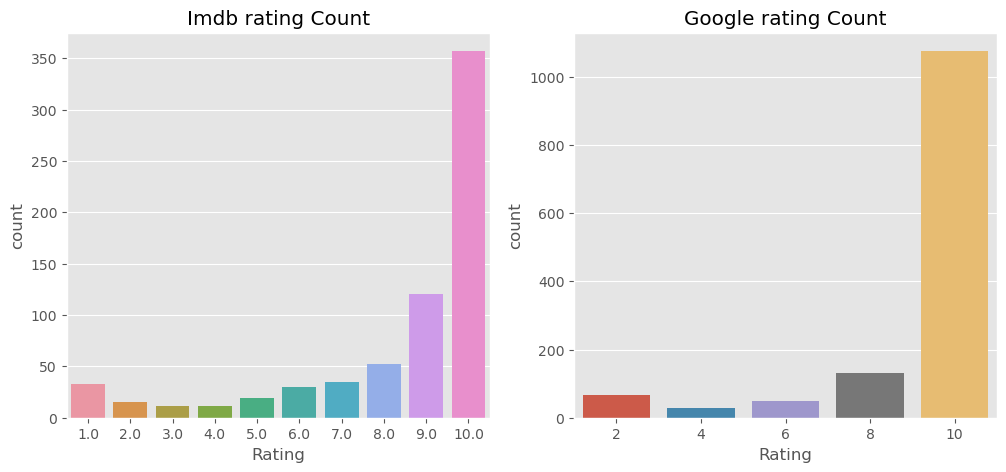

In [201]:
# Basic visualisation on google rating and Imdb ratings
fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.countplot(data=imdb_df,x="Rating",ax=ax[0])
sns.countplot(data=google_df,x="Rating",ax=ax[1])
ax[0].set_title("Imdb rating Count")
ax[1].set_title("Google rating Count")
plt.show()

In [ ]:
# The above plot cleary inferencing that most of the revies are 10 ratings whic means that online respone is very higher for this movie
# Most of the Non tamil people watched this movie in hotstar and post their response in google reviews, which means online response pretty higher

### 4. Filling missing detail

In [127]:
# Basic Ml to fill the rating for youtube data
# google and imdb data have rating column, but youtube data doesn't have any rating column, we have to create a new feature using text data
# NLTK has an amazing package which gives polarity scores for a given text

sm = SentimentIntensityAnalyzer()
sm.polarity_scores(youtube_df["Review_content"][0])

{'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'compound': 0.4215}

In [129]:
res = {}
count = 0 
for i, row in tqdm(youtube_df.iterrows(), total=len(youtube_df)):
    try:
        text = row['Review_content']
        myid = row['Users']
        res[myid] = sm.polarity_scores(text)
    except AttributeError:
        count+=1
        print(f"Attribute error on {i} row")
yt_df = pd.DataFrame(res).T
yt_df = yt_df.reset_index().rename(columns={'index':'Users'})
yt_df = yt_df.merge(youtube_df,how="left")
yt_df["Rating"] = round(abs(yt_df["compound"])*10,0)
yt_df.drop(["neg","neu","pos","compound"],axis=1,inplace=True)

  0%|          | 0/4519 [00:00<?, ?it/s]

Attribute error on 425 row
Attribute error on 531 row
Attribute error on 628 row
Attribute error on 632 row
Attribute error on 638 row
Attribute error on 643 row
Attribute error on 704 row
Attribute error on 749 row
Attribute error on 763 row
Attribute error on 768 row
Attribute error on 878 row
Attribute error on 890 row
Attribute error on 953 row
Attribute error on 964 row
Attribute error on 1003 row
Attribute error on 1004 row
Attribute error on 1009 row
Attribute error on 1015 row
Attribute error on 1019 row
Attribute error on 1096 row
Attribute error on 1135 row
Attribute error on 1150 row
Attribute error on 1187 row
Attribute error on 1211 row
Attribute error on 1218 row
Attribute error on 1228 row
Attribute error on 1279 row
Attribute error on 1366 row
Attribute error on 1445 row
Attribute error on 1485 row
Attribute error on 1516 row
Attribute error on 1859 row
Attribute error on 1961 row
Attribute error on 2053 row
Attribute error on 2095 row
Attribute error on 2123 row
Attrib

### 5. Data preperation

- We have cleaned the data
- Filled missing details
- created feature based on text with simple nlp

In [132]:
df1 = imdb_df.copy()
df2 = google_df.copy()
df3 = yt_df.copy()


df1.drop("Review_title",axis=1,inplace=True)
df3.rename(columns = {
    "User":"Users",
    "Date":"Review_date",
    "Review":"Review_content"
},inplace=True)

data = pd.concat([df1,df2,df3],ignore_index=True,axis=0)
data["Rating"] = data["Rating"]//2
data["char_count"] = data["Review_content"].apply(lambda x: len(str(x)))
data.dropna(inplace=True)
data["Review_content"] = data["Review_content"].apply(lambda x: remove_punct(clean(remove_emoji(x).lower())[0][0]))

In [139]:
data["tokenized_review"] = data.Review_content.apply(lambda x: tokenize(x))
data['tokenized_review'] = data['tokenized_review'].apply(lambda x: remove_punct(x))

## NLP - Natural Language processing

- Objective: Sentiment Analysis
- Data Transformation:
    - Transformed data to a format suitable for machine processing.
- Model Input:
    - Fed transformed data into a pretrained model for sentiment analysis.
    - Chose RoBERTa model, a pre-existing model trained on massive datasets.
- Categories of Response:
    - Model output consists of three sentiment categories:
        - Negative
        - Positive
        - Neutral
- Pretrained Model Usage:
    - Utilized pretrained RoBERTa model's weights for predictions.
    - Leverages the model's extensive training on diverse data.
- Prediction Process:
    - Model predicts sentiment category for each input data point.
Text Analytics EDA:
    - Once predictions are generated, conducted Text Analytics Exploratory Data Analysis (EDA).
- Outcome:
    - Obtained insights into sentiment distribution across the dataset.
- Summary:
    -The process involves transforming data, using a pretrained RoBERTa model for sentiment analysis, predicting sentiment categories, and finally, performing Text Analytics EDA to gain insights from the predictions.






In [141]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [49]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    score = softmax(scores).argmax()
    return score

In [144]:
res = []
for i, row in tqdm(data.iterrows(), total=len(data)):
    try:
        text = row['Review_content']
        myid = row['Users']
        roberta_result = polarity_scores_roberta(text)
        res.append(roberta_result)
    except RuntimeError:
        res.append(3)
        print(f'Broke for id {myid}')
    except IndexError:
        res.append(4)
        print(f'broke for id {myid}')
data["Responce_pretrained"] = res

  0%|          | 0/6392 [00:00<?, ?it/s]

Broke for id nidhunmoviebuff
Broke for id msunando
Broke for id OnjiMooteDaMarle
Broke for id cs_rahul_kumar
Broke for id MehdiRizvi-7867
Broke for id rajesh-puvvada
Broke for id naveensankaran18
Broke for id bijupillai73-1
Broke for id nadkarnisumeet
broke for id ngandacinema
Broke for id IdlyViswanath
Broke for id djpa-76657
Broke for id nickraman-27699
Broke for id jothishprabu
Broke for id natureboy-84907
Broke for id Saranbharathi_96
Broke for id s-15144-48886
Broke for id architectddeepika
Broke for id pratsawant
Broke for id glami-64433
Broke for id mendonmrinal
Broke for id devotionalsongs9792
Broke for id rajg3412
Broke for id anbudanvengat2949
Broke for id 2gspectrumcorruptiondmksta734
Broke for id anamikaananya2821
Broke for id pandiyansmart4169
Broke for id ttrrajkiranff4091
Broke for id user-fi9lk3ol6b
Broke for id chandramuniandy6343


In [145]:
data["Responce_pretrained"].value_counts()

2    3367
1    2726
0     269
3      29
4       1
Name: Responce_pretrained, dtype: int64

In [150]:
def label_name(x):
    if x == 0:
        return "Negative"
    elif x == 1:
        return "Neutral"
    else:
        return "Positive"

In [151]:
data = data.rename(columns={"Responce_pretrained":"label"})
data["label_name"] = data["label"].apply(lambda x: label_name(x))

## EDA - Exploratory Data Analysis

### Ratings based on the online response

- 1400+ reviewers gave 5 rating which means
- Ratings are already present in data
- We will look deeper on how each review is affecting the rating part


In [202]:
fig = px.histogram(data[data["Rating"]!=0],
             x = 'Rating',
             title = 'Histogram of Review Rating',
             template = 'ggplot2',
             color = 'Rating',
             color_discrete_sequence= px.colors.sequential.Blues_r,
             opacity = 0.8,
             height = 525,
             width = 835,
            )

fig.update_yaxes(title='Count')
fig.show()

### Word cloud on the review data

- A word cloud plot is a visual representation of text data, where the size of each word is proportional to its frequency or importance in the given text. It provides a quick and visually appealing way to understand the most common words or terms present in a piece of text. In a word cloud, frequently occurring words are typically displayed in larger font sizes and are arranged randomly, creating a cloud-like appearance.

- In the generated word cloud plot, the prominent words predominantly reflect a positive sentiment. Words like "appreciation," "compliment," and various greetings are the most frequent terms. This suggests that the overall sentiment of the text data is positive, with a focus on expressions of appreciation and compliments. The prevalence of these positive words indicates that the subject matter under analysis is likely associated with positive experiences or interactions.

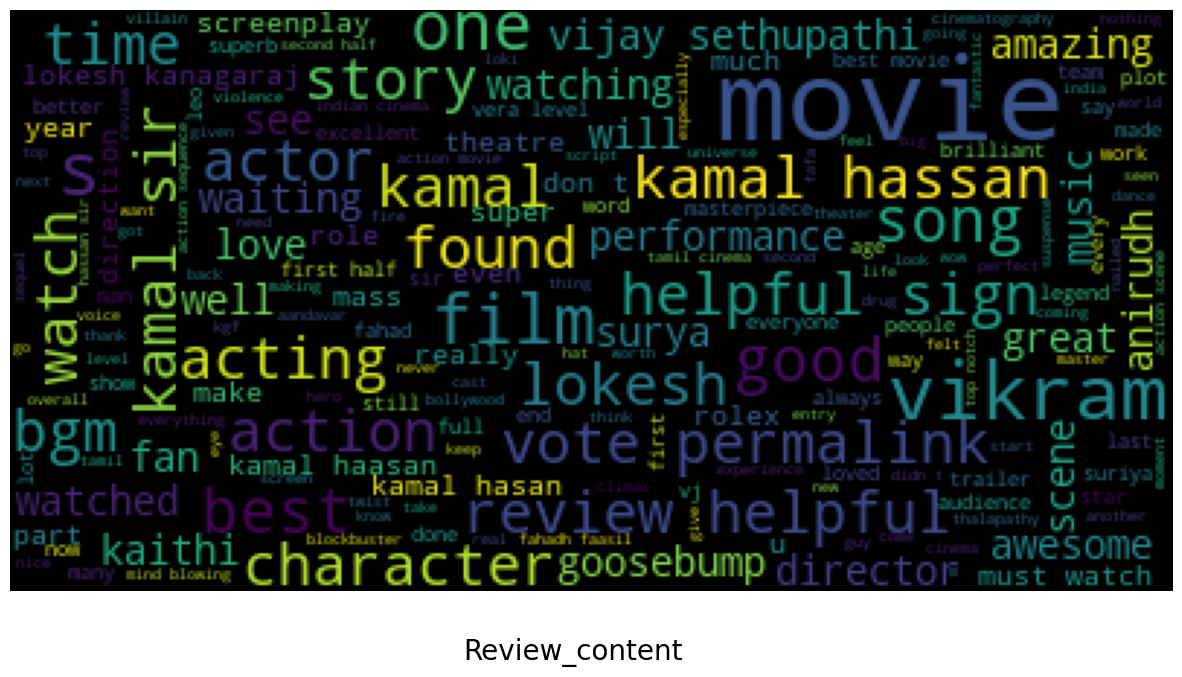

In [190]:
# Max_Words in Review

wordcloud = WordCloud(background_color='black',max_words=200,max_font_size=40, scale=1,random_state=1).generate(" ".join(data["Review_content"]))

fig = plt.figure(1, figsize=(15, 15))
plt.axis('off')
fig.suptitle("Review_content", fontsize=20)
fig.subplots_adjust(top=2.3)

plt.imshow(wordcloud)
plt.show()
# show_wordcloud(data["Review_content"].values)

### Pie plot on review data

- The sentiment distribution analysis reveals the following breakdown of responses:
    - Positive responses account for approximately 52.9% of the total sentiments. This suggests that the majority of users have expressed a favorable view towards the subject being analyzed.
    - About 42.8% of the responses fall within the neutral sentiment category. This indicates a significant portion of users providing feedback without leaning heavily towards either a positive or negative viewpoint.
    - Negative responses are relatively low, at approximately 4.23%. This indicates that only a small fraction of users have expressed a negative sentiment towards the subject.
- Overall, the sentiment analysis demonstrates that the subject has garnered predominantly positive and neutral responses, with a minimal percentage of negative feedback.

In [154]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "bar"}]])
colors = ['gold', 'mediumturquoise', 'lightgreen'] # darkorange
fig.add_trace(go.Pie(labels=data.label_name.value_counts().index,
                             values=data.label.value_counts().values), 1, 1)

fig.update_traces(hoverinfo='label+percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.add_trace(go.Bar(x=data.label_name.value_counts().index, y=data.label.value_counts().values, marker_color = colors), 1,2)

fig.show()

### Character count for each review

#### Character count for total data

- The majority of the reviews provided for the movie fall within a consistent range of around 30 to 40 words in length. This observation highlights the trend of reviewers succinctly expressing their opinions and feedback in a concise manner. This pattern of brevity suggests that reviewers are inclined to convey their thoughts efficiently, possibly due to the nature of the platform or the desire to capture the essence of their review in a limited space. This consistent word count range indicates a standardized way of sharing opinions among users, which could be attributed to the platform's design or user preferences.

Text(0.5, 1.0, 'Characters Count in Data')

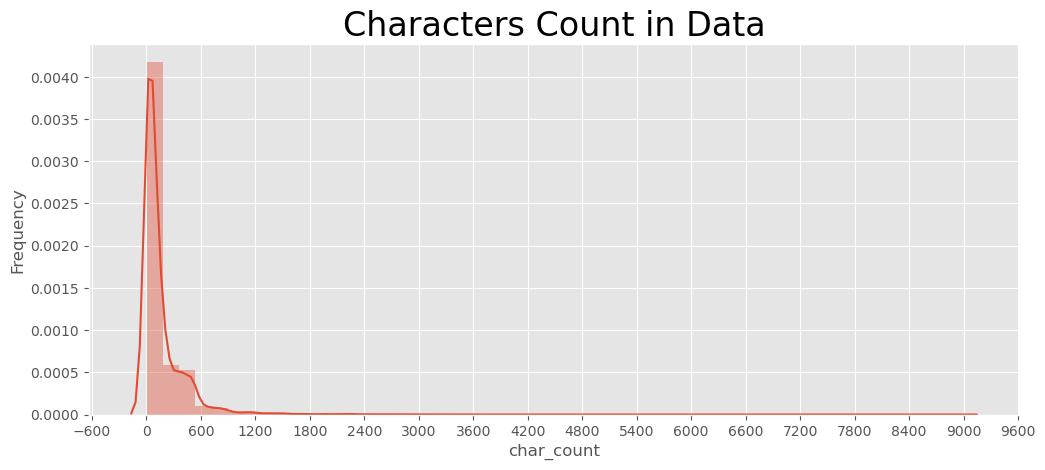

In [181]:
fig = plt.figure(constrained_layout=True, figsize=(15, 12))
grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
ax1 = fig.add_subplot(grid[0, :2])
ax1.set_title('Histogram')
sns.distplot(data.loc[:, 'char_count'],hist=True,kde=True,ax=ax1,)
ax1.set(ylabel='Frequency')
ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.title(f'Characters Count in Data', fontsize=24)
# plot_dist3(data, 'char_count',
#            'Characters Count in Data')

#### Character count based on Positive review

- A notable observation is that a significant portion of the positive responses corresponds to a word count of around 600. This trend is further evident in the Empirical Cumulative Distribution Function (ECDF) plot, which showcases the distribution of positive responses across various word counts. The ECDF curve reveals that the cumulative proportion of positive responses with a word count of approximately 600 is relatively high
- This alignment between the actual distribution and the ECDF underscores the consistency of positive reviews being elaborated upon within a specific range of word count, in this case, around 600 words.

[Text(0, 0.5, 'Cumulative Probability')]

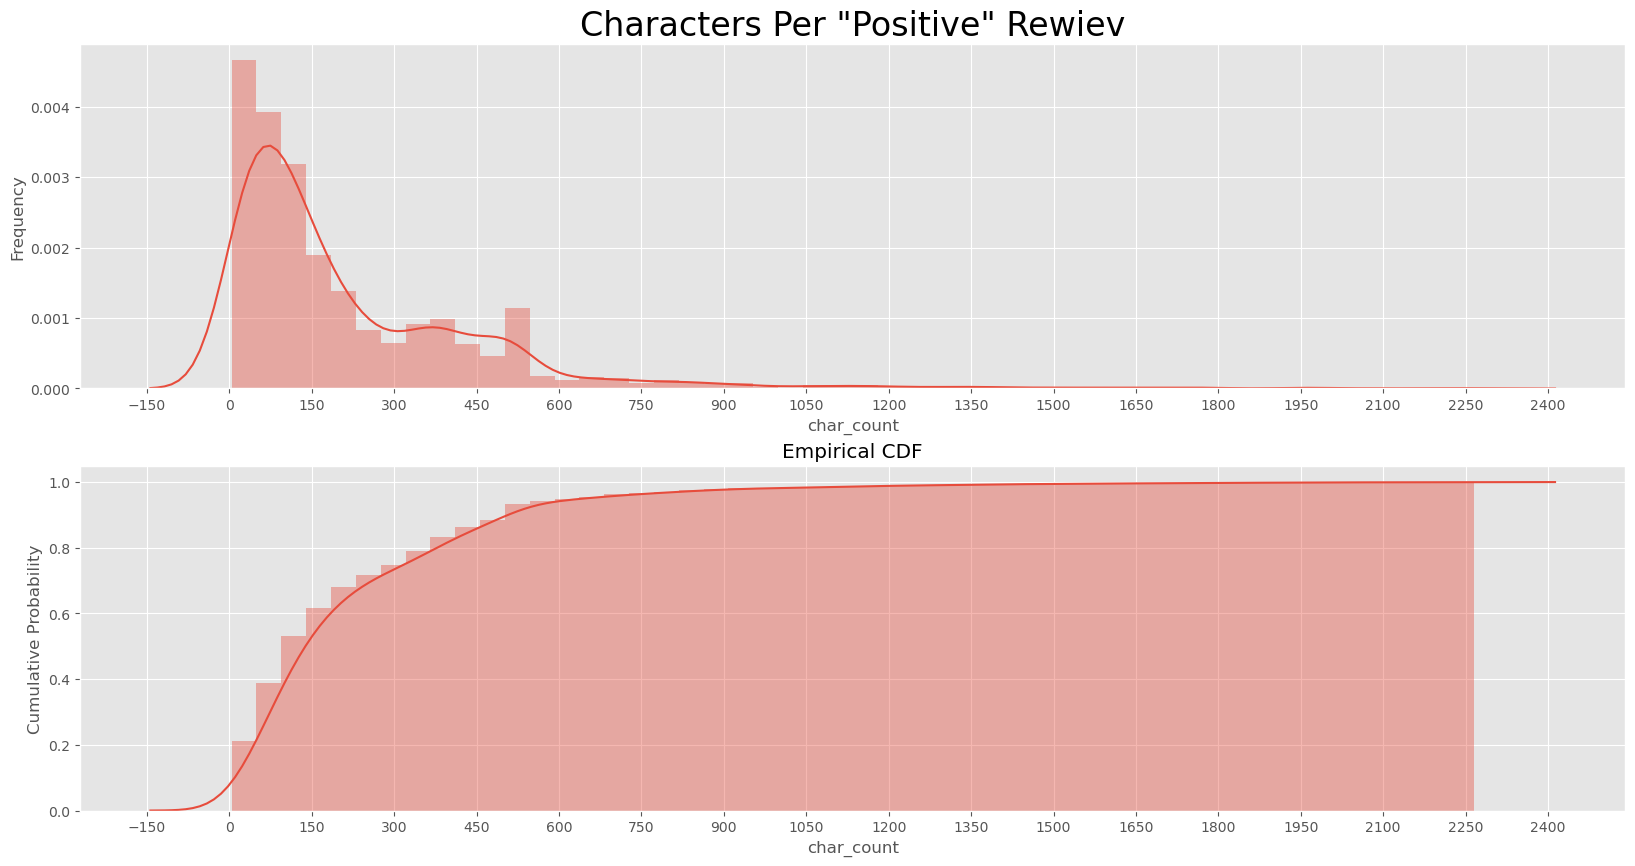

In [183]:

fig = plt.figure(constrained_layout=True, figsize=(24, 12))
grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

ax1 = fig.add_subplot(grid[0, :2])
ax1.set_title('Histogram')
sns.distplot(data[data['label'] == 2].loc[:, "char_count"],hist=True,kde=True,ax=ax1,color='#e74c3c')
ax1.set(ylabel='Frequency')
ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

plt.title("Characters Per \"Positive\" Rewiev", fontsize=24)

ax2 = fig.add_subplot(grid[1, :2])
ax2.set_title('Empirical CDF')
sns.distplot(data[data['label'] == 2].loc[:, "char_count"],ax=ax2,kde_kws={'cumulative': True},hist_kws={'cumulative': True},color='#e74c3c')
ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
ax2.set(ylabel='Cumulative Probability')



#### Character count based on Negative review
- Notably, the majority of negative responses appear to be concentrated around a word count of approximately 300.
- This trend is reaffirmed by examining the Empirical Cumulative Distribution Function (ECDF) plot for negative responses.
- The ECDF graph illustrates that a substantial portion of negative reviews corresponds to a word count of around 300.
- The consistency between the observed distribution and the ECDF curve suggests that negative responses tend to be expressed within a specific range of word count, primarily around 300 words.

[Text(0, 0.5, 'Cumulative Probability')]

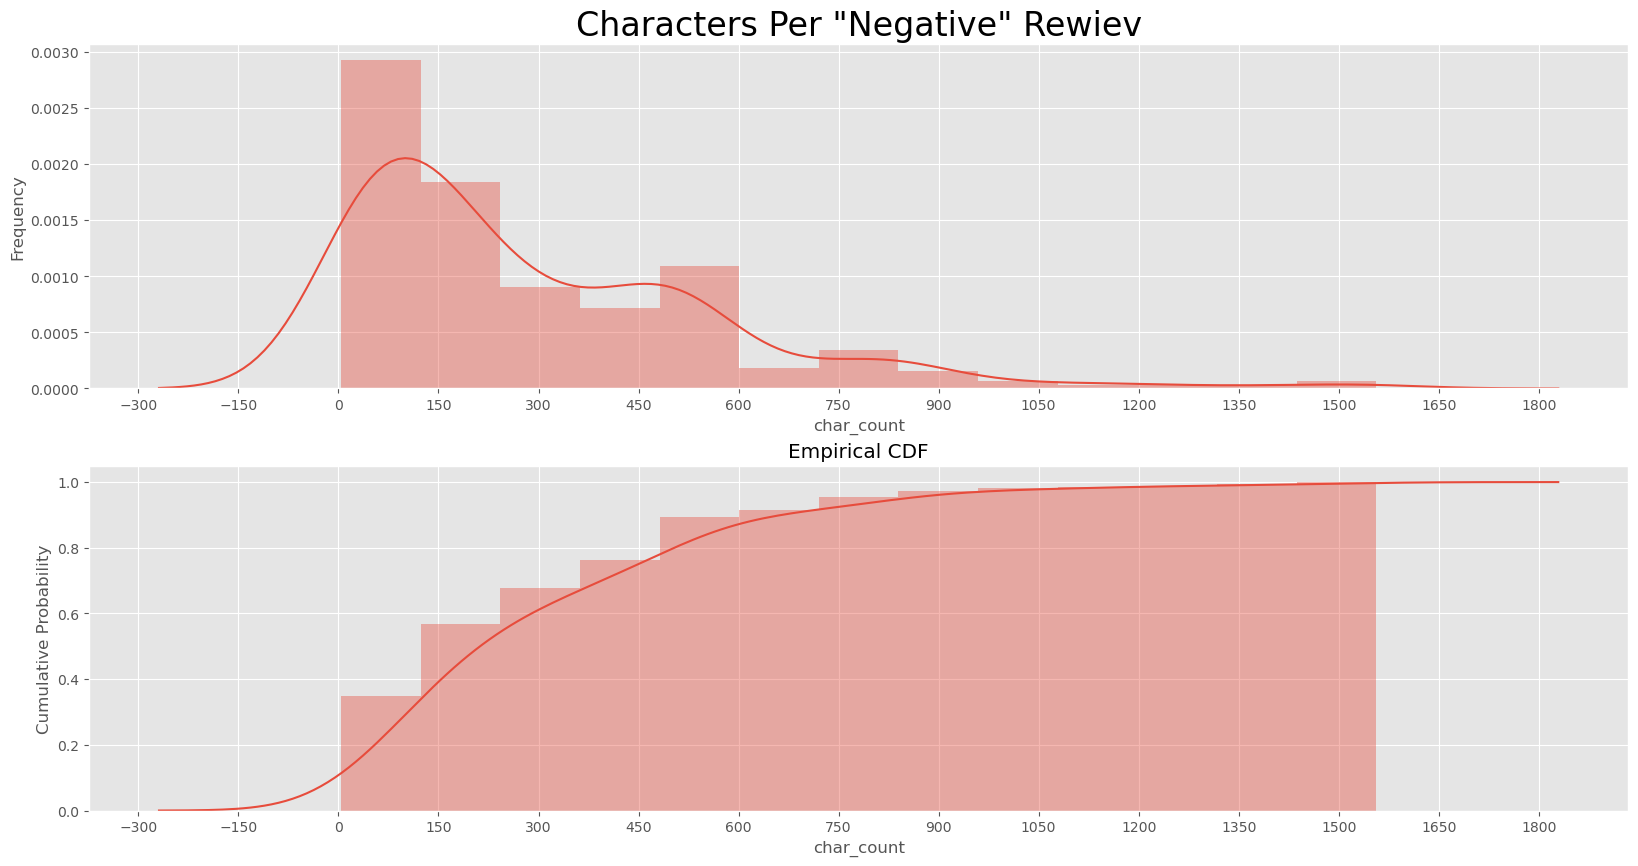

In [184]:
fig = plt.figure(constrained_layout=True, figsize=(24, 12))
grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
ax1 = fig.add_subplot(grid[0, :2])

ax1.set_title('Histogram')
sns.distplot(data[data['label'] == 0].loc[:, "char_count"],hist=True,kde=True,ax=ax1,color='#e74c3c')
ax1.set(ylabel='Frequency')
ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

plt.title("Characters Per \"Negative\" Rewiev", fontsize=24)

ax2 = fig.add_subplot(grid[1, :2])
ax2.set_title('Empirical CDF')
sns.distplot(data[data['label'] == 0].loc[:, "char_count"],ax=ax2,kde_kws={'cumulative': True},hist_kws={'cumulative': True},color='#e74c3c')
ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
ax2.set(ylabel='Cumulative Probability')



#### Character count based on Neutral review

- A significant portion of neutral responses appears to cluster around a word count of approximately 150.
- This observation aligns closely with the cumulative distribution pattern depicted by the Empirical Cumulative Distribution Function (ECDF) plot for neutral responses.
- The ECDF curve illustrates that a notable proportion of neutral reviews corresponds to a word count of around 150.
- The congruity between the observed data distribution and the ECDF plot suggests that neutral responses tend to exhibit a characteristic word count, particularly centered around 150 words.

[Text(0, 0.5, 'Cumulative Probability')]

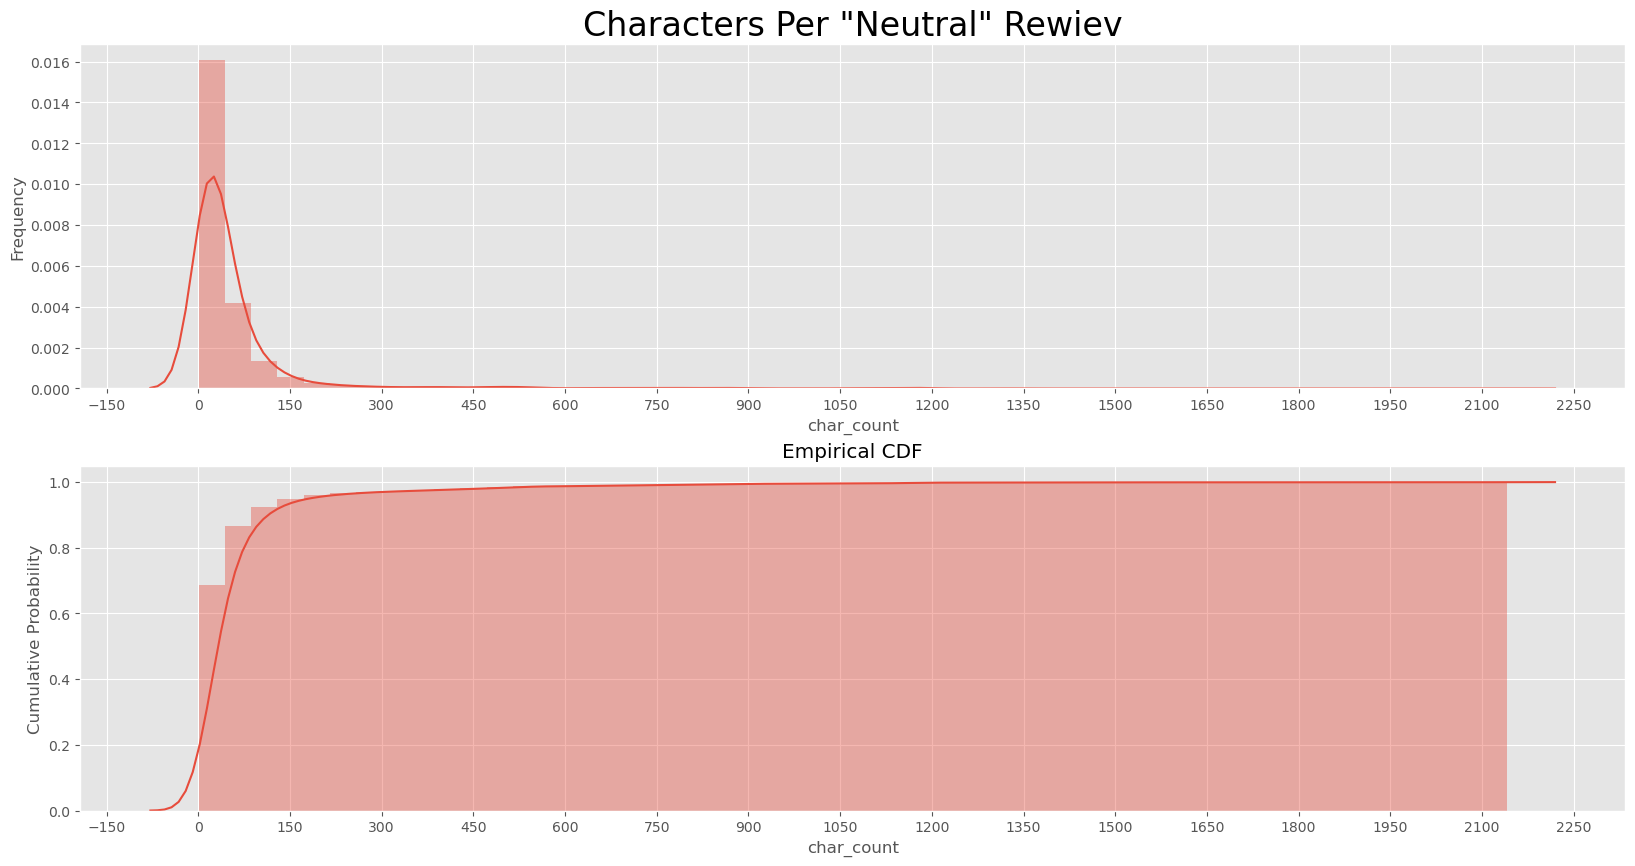

In [185]:
fig = plt.figure(constrained_layout=True, figsize=(24, 12))
grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

ax1 = fig.add_subplot(grid[0, :2])
ax1.set_title('Histogram')
sns.distplot(data[data['label'] == 1].loc[:, "char_count"],hist=True,kde=True,ax=ax1,color='#e74c3c')
ax1.set(ylabel='Frequency')
ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

plt.title("Characters Per \"Neutral\" Rewiev", fontsize=24)

ax2 = fig.add_subplot(grid[1, :2])
ax2.set_title('Empirical CDF')
sns.distplot(data[data['label'] == 1].loc[:, "char_count"],ax=ax2,kde_kws={'cumulative': True},hist_kws={'cumulative': True},color='#e74c3c')
ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
ax2.set(ylabel='Cumulative Probability')



### Most common words

- Among the most frequent words extracted from the reviews, "Movie," "Kamal," "Vikram," "Lokesh," and "Rolex" stand out as the most common.
- These words appear prominently and repeatedly in the text data, indicating that they are significant keywords associated with the subject matter of the movie
- The presence of these words suggests that they are central to discussions, opinions, and sentiments expressed in the reviews.
- These common words might provide insights into key aspects of the movie that have garnered attention and discussion among viewers.

In [171]:
texts = data['tokenized_review']
new = texts.str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]
counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word, count in most[:30]:
    if word not in stopWords_nltk:
        x.append(word)
        y.append(count)

fig = go.Figure(go.Bar(
            x=y,
            y=x,
            orientation='h',  marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='Most common Word',))

fig.update_layout( title={
        'text': "Most Common Words",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ))

fig.show()

In [192]:
def _get_top_ngram(corpus, n=None):
    #getting top ngrams
    vec = CountVectorizer(ngram_range=(n, n),
                          max_df=0.9,
                          ).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:15]

#### Most Common ngram per class

- The n-grams "Best," "Movie," "Kamal," and "Vikram" are the most frequently occurring combinations of words in the extracted data.
- These n-grams are likely to represent phrases or expressions commonly associated with the movie  under analysis.
- The prominence of these n-grams suggests that they are indicative of the positive sentiments, opinions, or discussions related to the content.
- These frequently occurring n-grams could provide valuable insights into the aspects of the movie that have garnered positive attention and praise from the audience.
- Analyzing these n-grams can help to uncover patterns and trends in the way viewers perceive and talk about the content.

In [193]:
fig = make_subplots(rows=1, cols=3)
title_ = ["negative", "neutral", "positive"]

for i in range(3):
    texts = data[data["label"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []

    for word, count in most[:30]:
        if word not in stopWords_nltk:
            x.append(word)
            y.append(count)

    fig.add_trace(go.Bar(x=y,y=x,orientation='h', type="bar",name=title_[i], marker=dict(color=colors[i])), 1, i+1)
    
fig.update_layout(autosize=False,width=1300,height=600,title=dict(text='<b>Most Common ngrams per Classes</b>',x=0.5,y=0.95,font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ),)

fig.show()


In [194]:
fig = make_subplots(rows=1, cols=3)

title_ = ["negative", "neutral", "positive"]

for i in range(3):
    texts = data[data["label"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    top_n_bigrams = _get_top_ngram(texts, 2)[:15]
    x, y = map(list, zip(*top_n_bigrams))


    fig.add_trace(go.Bar(x=y,y=x,orientation='h', type="bar",name=title_[i], marker=dict(color=colors[i])), 1, i+1)
    

fig.update_layout(autosize=False,width=1300,height=600,title=dict(
                                                        text='<b>Most Common unigrams per Classes</b>',
                                                        x=0.5,
                                                        y=0.95,
                                                        font=dict(
                                                            family="Courier New, monospace",
                                                            size=24,
                                                            color="RebeccaPurple")))      
fig.show()

## Insightful story

### Title: "Sentiment analysis: Unveiling the Success of 'Vikram'"

- In the digital age, the internet has become a hub for people to share their thoughts and opinions on various topics, including the latest movies and TV shows. Recently, the spotlight has been on the much-anticipated release of "Vikram" As the curtains went up, so did the excitement of fans and critics alike, and the online world buzzed with sentiments that painted a vivid picture of the film's reception.

- As we delved into the virtual conversations surrounding "Vikram" we uncovered a landscape teeming with appreciation, compliments, and greetings. The word cloud that emerged from the reviews was a testament to the positive energy that the film had generated among its audience. The words seemed to radiate enthusiasm, indicating a sense of satisfaction and enjoyment.

- Upon analyzing the sentiments, we found that a significant 52.9% of responses were overwhelmingly positive. Audiences couldn't help but express their delight through their words, highlighting the impact that the film had on their hearts. The film's ability to evoke such positive reactions showcased its ability to resonate with a wide range of viewers.

- Equally intriguing was the 42.8% of neutral responses, indicative of a contemplative and measured reception. It seemed that the film had invoked thought and reflection, prompting viewers to ponder its themes and storytelling nuances. This substantial neutral sentiment indicated that the film had sparked conversations and left an indelible mark on the minds of those who experienced it.

- Intriguingly, even the negative sentiments, albeit at 4.23%, couldn't dampen the overall positive reception. These candid expressions of dissatisfaction offered valuable feedback to the creators, underscoring their commitment to constantly improving their craft. It was heartening to witness the audience's willingness to provide constructive criticism, contributing to a culture of growth in the entertainment landscape.

- Word counts further echoed the audience's engagement. The majority of reviews featured concise yet impactful descriptions, with around 30 to 40 words being the norm. This brevity revealed a keen desire to express opinions succinctly, capturing the essence of the film in a few carefully chosen words.

- Digging deeper into the data, we unveiled the intriguing popularity of specific phrases, or n-grams. Among these, "Best," "Movie," "Kamal," and "Vikram" emerged as the most frequent. These n-grams weren't just words; they encapsulated the heart of the conversations. The prevalence of these phrases was a reflection of the movie's compelling storyline and the stellar performances of its cast, particularly Kamal and Vikram.

- As we embarked on this journey of exploration through data, the story that unfolded was one of triumph. The sentiments, the word counts, and the n-grams formed a mosaic that celebrated the success of "Movie Name." The film had not only captured the audience's attention but had also managed to resonate with them on a profound level.

- The online community's response was a testament to the film's ability to inspire, entertain, and provoke thought. It highlighted the power of storytelling and how it could bridge gaps, evoke emotions, and bring people together, even in the virtual realm. "Movie Name" had carved a place in the hearts of its audience, leaving an impression that would resonate long after the closing credits rolled.

- In an era where digital conversations are the new measure of a film's impact, "Vikram" had certainly left its mark, not just on the big screen but in the vast landscape of online discussions. As the curtains drew to a close on our analysis, it was evident that this cinematic masterpiece had not just entertained; it had become a part of a global dialogue, uniting fans and critics in the shared joy of cinematic brilliance.